# Data preprocessing
Loading the financial data and preparing it for training

In [23]:
import pandas as pd
import numpy as np


In [24]:

# Load the data
data = pd.read_csv('^GSPC_2010-2015.csv')  # Replace with the actual file path

# Feature engineering
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
data['Return'] = data['Adj Close'].pct_change()
data = data.dropna()

# Normalizing the data
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
data[features] = data[features].apply(lambda x: (x - x.mean()) / x.std())

# Prepare state representation (e.g., window of past prices)
window_size = 10
states = []
for i in range(window_size, len(data)):
    state = data[features].iloc[i-window_size:i].values
    states.append(state)
states = np.array(states)

# Prepare actions (0: hold, 1: buy, 2: sell)
actions = data['Adj Close'].iloc[window_size:].values



# Define the Environment
Defining the custom environment for trading task

In [25]:
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

In [26]:
# Define the network architecture
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [27]:

# Define the replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.index = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.index] = (state, action, reward, next_state, done)
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size):
        batch = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in batch:
            state, action, reward, next_state, done = self.buffer[i]
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
        return (
            torch.tensor(np.array(states)).float(),
            torch.tensor(np.array(actions)).long(),
            torch.tensor(np.array(rewards)).unsqueeze(1).float(),
            torch.tensor(np.array(next_states)).float(),
            torch.tensor(np.array(dones)).unsqueeze(1).int()
        )

    def __len__(self):
        return len(self.buffer)

In [45]:

# Define the custom trading environment
class TradingEnv(gym.Env):
    def __init__(self, states, prices, initial_balance=10000):
        super(TradingEnv, self).__init__()
        self.states = states
        self.prices = prices
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.holdings = 0
        self.portfolio_value = initial_balance
        self.current_step = 0

        # Action space: [hold, buy, sell]
        self.action_space = spaces.Discrete(3)
        # State space
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(states.shape[1], states.shape[2]), dtype=np.float32)

    def reset(self):
        self.balance = self.initial_balance
        self.holdings = 0
        self.portfolio_value = self.initial_balance
        self.current_step = 0
        return self.states[self.current_step]

    def step(self, action):
        current_price = self.prices[self.current_step]
        if action == 1:  # Buy
            self.holdings += self.balance / current_price
            self.balance = 0
        elif action == 2:  # Sell
            self.balance += self.holdings * current_price
            self.holdings = 0

        self.current_step += 1
        self.portfolio_value = self.balance + self.holdings * self.prices[self.current_step]

        done = self.current_step == len(self.states) - 1
        reward = self.portfolio_value

        next_state = self.states[self.current_step]
        return next_state, reward, done, {}

    def render(self):
        pass

env = TradingEnv(states, actions)


# DDQN Agent
Adapting ddqn agent to handle trading environment

In [29]:
# Define the Double DQN agent
class DDQNAgent:
    def __init__(self, state_size, action_size, seed, learning_rate=1e-3, capacity=1000000,
                 discount_factor=0.99, tau=1e-3, update_every=4, batch_size=64):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = seed
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.tau = tau
        self.update_every = update_every
        self.batch_size = batch_size
        self.steps = 0

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.qnetwork_local = QNetwork(state_size, action_size).to(self.device)
        self.qnetwork_target = QNetwork(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=learning_rate)
        self.replay_buffer = ReplayBuffer(capacity)
        self.update_target_network()
        
        

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay buffer
        self.replay_buffer.push(state, action, reward, next_state, done)

        # Learn every update_every steps
        self.steps += 1
        if self.steps % self.update_every == 0:
            if len(self.replay_buffer) > self.batch_size:
                experiences = self.replay_buffer.sample(self.batch_size)
                self.learn(experiences)
                
    def act(self, state, eps=0.0):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        state = state.view(state.size(0), -1)  # Flatten the state
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(list(range(self.action_size)))

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # Move tensors to the correct device
        states = states.to(self.device).view(self.batch_size, -1)  # Flatten the state
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device).view(self.batch_size, -1)  # Flatten the state
        dones = dones.to(self.device)

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + self.discount_factor * (Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions.view(-1, 1))

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target)


    def update_target_network(self):
        # Update target network parameters with polyak averaging
        for target_param, local_param in zip(self.qnetwork_target.parameters(), self.qnetwork_local.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the environment and agent
env = TradingEnv(states, actions)
state_size = env.observation_space.shape[0] * env.observation_space.shape[1]  # Flatten the state size
action_size = env.action_space.n
seed = 0

agent = DDQNAgent(state_size, action_size, seed)

# Set the number of episodes and the maximum number of steps per episode
num_episodes = 1000
max_steps = len(states) - 1

# Set the exploration rate
eps = eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995

# Set the rewards and portfolio value lists
rewards = []
portfolio_values = []


In [31]:

# Run the training loop
for i_episode in range(num_episodes):
    print(f'Episode: {i_episode}')
    state = env.reset()
    portfolio_value = env.initial_balance
    score = 0
    eps = max(eps_end, eps_decay * eps)
    
    for t in range(max_steps):
        state = state.flatten()  # Flatten the state
        action = agent.act(state, eps)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state.flatten(), done)
        state = next_state
        portfolio_value = env.portfolio_value
        score += reward
        if done:
            break
        
    print(f"\tScore: {score}, Portfolio Value: {portfolio_value}, Epsilon: {eps}")
    rewards.append(score)
    portfolio_values.append(portfolio_value)
    
# Close the environment
env.close()

Episode: 0
	Score: 415613791.6496869, Portfolio Value: 692212.3933272684, Epsilon: 0.995
Episode: 1
	Score: -33411503.037742313, Portfolio Value: -36710.815750590846, Epsilon: 0.990025
Episode: 2
	Score: 24743737.039109774, Portfolio Value: 37701.06161974271, Epsilon: 0.985074875
Episode: 3
	Score: 7943119.551537529, Portfolio Value: 94.09349674154468, Epsilon: 0.9801495006250001
Episode: 4
	Score: 3721571.2496781168, Portfolio Value: -1021.4568823536525, Epsilon: 0.9752487531218751
Episode: 5
	Score: 6640374.576087725, Portfolio Value: 541.3981556562649, Epsilon: 0.9703725093562657
Episode: 6
	Score: 6767377.415002761, Portfolio Value: 1713.5975375162066, Epsilon: 0.9655206468094844
Episode: 7
	Score: 8496582.018545246, Portfolio Value: 1370.706900741913, Epsilon: 0.960693043575437
Episode: 8
	Score: 23221509.434149493, Portfolio Value: 18653.470152597096, Epsilon: 0.9558895783575597
Episode: 9
	Score: 5323848.419545509, Portfolio Value: -104.33540134004897, Epsilon: 0.951110130465771

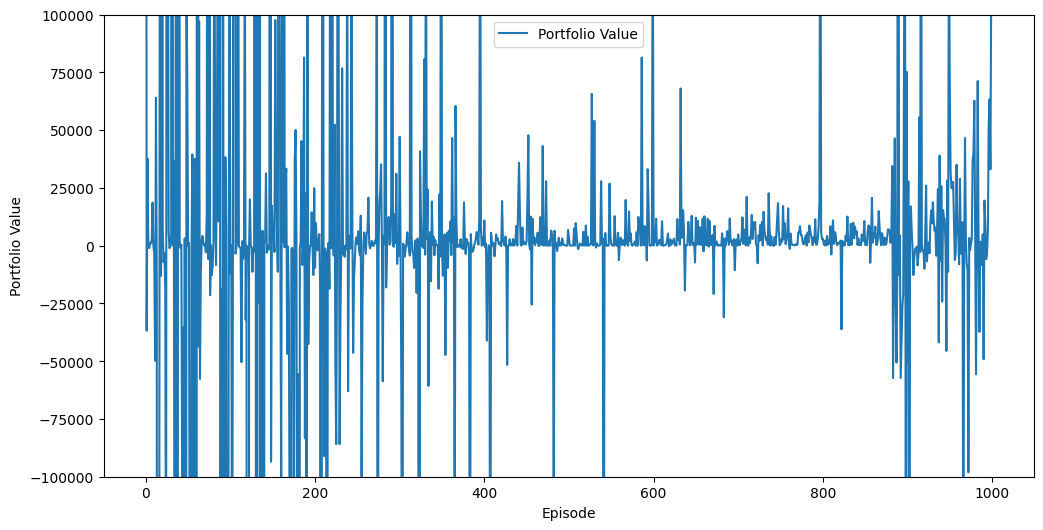

In [33]:
# Plot the portfolio value
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label='Portfolio Value')
plt.xlabel('Episode')
plt.ylabel('Portfolio Value')
plt.ylim(-100000, 100000)
plt.legend()
plt.show()

In [34]:
# Save the trained model
torch.save(agent.qnetwork_local.state_dict(), 'ddqn_trading_model.pth')


In [72]:
# Function to load the model
def load_model(model_path, state_size, action_size):
    model = QNetwork(state_size, action_size)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Load and preprocess the data
data = pd.read_csv('^GSPC_2014.csv')  # Replace with your actual data file
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
data['Return'] = data['Adj Close'].pct_change()
data = data.dropna()

# Keep original prices for plotting
original_prices = data['Adj Close'].values

# Normalizing the data
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
data[features] = data[features].apply(lambda x: (x - x.mean()) / x.std())

# Prepare state representation
window_size = 10
states = []
for i in range(window_size, len(data)):
    state = data[features].iloc[i-window_size:i].values
    states.append(state)
states = np.array(states)
actions = data['Adj Close'].iloc[window_size:].values
original_prices = original_prices[window_size:]



Here, I have made some changes in trading env to store original stock prices (Initially I was storing only normalised prices and also here I have stored number of stocks bought and sold.)
I have made the environment again because that first environment was made before training and training took so much time so if I make some changes there then I have to also make changes at some other places in training code and for checking whether code is working correctly or not I would have to train the model again that I don't want.
So if someone wants to train model on new dataset he has to just put that dataset name at start and run the cells in order that first env will be used for training and this env will be used for evaluation.

In [73]:
class TradingEnv(gym.Env):
    def __init__(self, states, prices, original_prices, initial_balance=10000):
        super(TradingEnv, self).__init__()
        self.states = states
        self.prices = prices
        self.original_prices = original_prices  # Store original prices
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.holdings = 0
        self.portfolio_value = initial_balance
        self.current_step = 0

        # Action space: [hold, buy, sell]
        self.action_space = spaces.Discrete(3)
        # State space
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(states.shape[1], states.shape[2]), dtype=np.float32)

    def reset(self):
        self.balance = self.initial_balance
        self.holdings = 0
        self.portfolio_value = self.initial_balance
        self.current_step = 0
        return self.states[self.current_step]

    def step(self, action):
        current_price = self.prices[self.current_step]
        num_shares_bought = 0
        num_shares_sold = 0

        if action == 1:  # Buy
            num_shares_bought = self.balance / current_price
            self.holdings += num_shares_bought
            self.balance = 0
        elif action == 2:  # Sell
            num_shares_sold = self.holdings
            self.balance += self.holdings * current_price
            self.holdings = 0

        self.current_step += 1
        self.portfolio_value = self.balance + self.holdings * self.prices[self.current_step]

        done = self.current_step == len(self.states) - 1
        reward = self.portfolio_value

        next_state = self.states[self.current_step]
        return next_state, reward, done, {'num_shares_bought': num_shares_bought, 'num_shares_sold': num_shares_sold}

    def render(self):
        pass


In [74]:
# Function to evaluate the model on a new dataset
def evaluate_model(model, env):
    state = env.reset()
    initial_portfolio_value = env.initial_balance  # Initial portfolio value
    done = False
    portfolio_values = [env.portfolio_value]
    actions = []
    buy_points = []
    sell_points = []

    while not done:
        state = state.flatten()
        state_tensor = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            action_values = model(state_tensor)
        action = np.argmax(action_values.cpu().data.numpy())
        next_state, _, done, _ = env.step(action)  # We don't need the reward here
        state = next_state
        portfolio_values.append(env.portfolio_value)
        actions.append(action)
        
        # Track buy/sell actions with original prices
        if action == 1:  # Buy
            buy_points.append((env.current_step, env.original_prices[env.current_step]))
        elif action == 2:  # Sell
            sell_points.append((env.current_step, env.original_prices[env.current_step]))
    
    final_portfolio_value = portfolio_values[-1]
    roi = (final_portfolio_value - initial_portfolio_value) / initial_portfolio_value  # Calculate ROI
    return initial_portfolio_value, final_portfolio_value, roi, portfolio_values, actions, buy_points, sell_points

# Load the new dataset
new_data = pd.read_csv('^GSPC_2014.csv')  # Replace with your new data file
new_data['Date'] = pd.to_datetime(new_data['Date'])
new_data = new_data.sort_values('Date')
new_data['Return'] = new_data['Adj Close'].pct_change()
new_data = new_data.dropna()

# Keep original prices for plotting
new_original_prices = new_data['Adj Close'].values

# Normalizing the new data
new_data[features] = new_data[features].apply(lambda x: (x - x.mean()) / x.std())

# Prepare new state representation
new_states = []
for i in range(window_size, len(new_data)):
    state = new_data[features].iloc[i-window_size:i].values
    new_states.append(state)
new_states = np.array(new_states)
new_actions = new_data['Adj Close'].iloc[window_size:].values
new_original_prices = new_original_prices[window_size:]

# Instantiate the new environment
new_env = TradingEnv(new_states, new_actions, new_original_prices)

# Load the trained model
trained_model = load_model('ddqn_trading_model.pth', state_size, action_size)

# Evaluate the model on the new dataset
initial_portfolio_value, final_portfolio_value, roi, portfolio_values, actions, buy_points, sell_points = evaluate_model(trained_model, new_env)

# Print the initial and final portfolio values, ROI, and buy/sell points
print(f'Initial Portfolio Value: {initial_portfolio_value}')
print(f'Final Portfolio Value: {final_portfolio_value}')
print(f'Return on Investment (ROI): {roi * 100:.2f}%')

print("\nBuy Points:")
for step, price in buy_points:
    print(f"Step: {step}, Price: {price}")

print("\nSell Points:")
for step, price in sell_points:
    print(f"Step: {step}, Price: {price}")


Initial Portfolio Value: 10000
Final Portfolio Value: 112722.33317191053
Return on Investment (ROI): 1027.22%

Buy Points:
Step: 104, Price: 1956.97998
Step: 105, Price: 1959.47998
Step: 139, Price: 1909.569946
Step: 147, Price: 1981.599976
Step: 185, Price: 1874.73999
Step: 193, Price: 1950.819946
Step: 196, Price: 1985.050049

Sell Points:
Step: 137, Price: 1920.209961
Step: 183, Price: 1928.209961


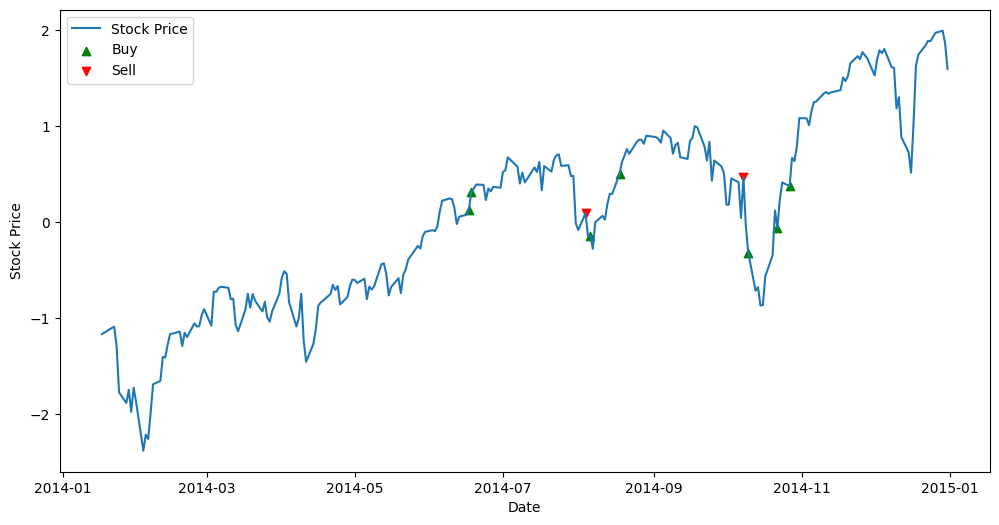

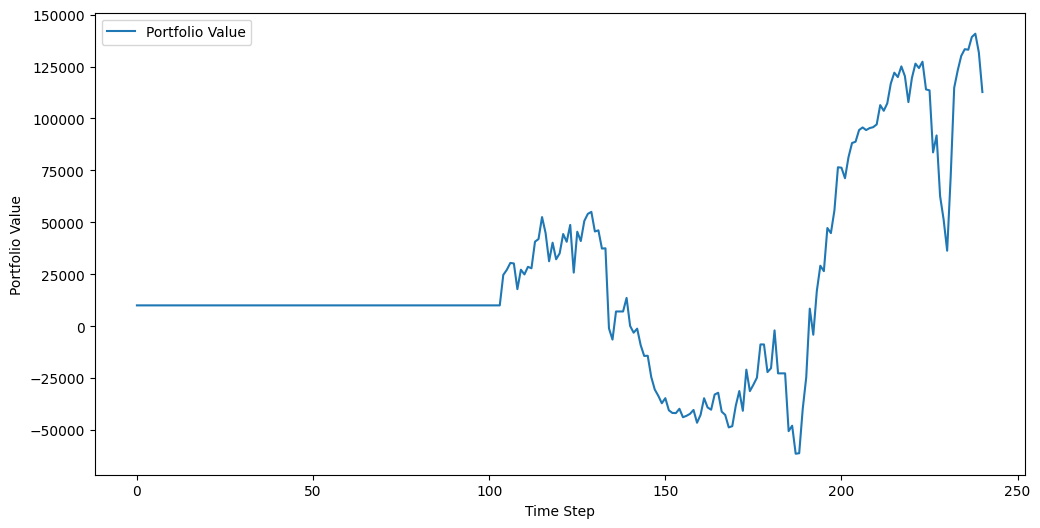

In [75]:
# Get the dates and prices from the new dataset
dates = new_data['Date'].iloc[window_size:]
prices = new_data['Adj Close'].iloc[window_size:]

# Identify buy and sell points
buy_points = []
sell_points = []
for i, action in enumerate(actions):
    if action == 1:  # Buy
        buy_points.append((dates.iloc[i], prices.iloc[i]))
    elif action == 2:  # Sell
        sell_points.append((dates.iloc[i], prices.iloc[i]))

# Plot the stock price with buy/sell indicators
plt.figure(figsize=(12, 6))
plt.plot(dates, prices, label='Stock Price')
if buy_points:
    plt.scatter(*zip(*buy_points), marker='^', color='g', label='Buy')
if sell_points:
    plt.scatter(*zip(*sell_points), marker='v', color='r', label='Sell')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Plot the portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label='Portfolio Value')
plt.xlabel('Time Step')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()


Checking results of different datasets
I haven't kept this entire preprocessing, result extraction & plotting code for evaluation purpose in a function.
So for now I have to paste the above code again for testing on new dataset.

In [76]:
# Function to load the model
def load_model(model_path, state_size, action_size):
    model = QNetwork(state_size, action_size)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model


# Load and preprocess the data
data = pd.read_csv('^GSPC_2000-2017.csv')  # Replace with your actual data file
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
data['Return'] = data['Adj Close'].pct_change()
data = data.dropna()

# Keep original prices for plotting
original_prices = data['Adj Close'].values

# Normalizing the data
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
data[features] = data[features].apply(lambda x: (x - x.mean()) / x.std())

# Prepare state representation
window_size = 10
states = []
for i in range(window_size, len(data)):
    state = data[features].iloc[i-window_size:i].values
    states.append(state)
states = np.array(states)
actions = data['Adj Close'].iloc[window_size:].values
original_prices = original_prices[window_size:]



In [77]:
# Function to evaluate the model on a new dataset
def evaluate_model(model, env):
    state = env.reset()
    initial_portfolio_value = env.initial_balance  # Initial portfolio value
    done = False
    portfolio_values = [env.portfolio_value]
    actions = []
    buy_points = []
    sell_points = []

    while not done:
        state = state.flatten()
        state_tensor = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            action_values = model(state_tensor)
        action = np.argmax(action_values.cpu().data.numpy())
        next_state, _, done, _ = env.step(action)  # We don't need the reward here
        state = next_state
        portfolio_values.append(env.portfolio_value)
        actions.append(action)
        
        # Track buy/sell actions with original prices
        if action == 1:  # Buy
            buy_points.append((env.current_step, env.original_prices[env.current_step]))
        elif action == 2:  # Sell
            sell_points.append((env.current_step, env.original_prices[env.current_step]))
    
    final_portfolio_value = portfolio_values[-1]
    roi = (final_portfolio_value - initial_portfolio_value) / initial_portfolio_value  # Calculate ROI
    return initial_portfolio_value, final_portfolio_value, roi, portfolio_values, actions, buy_points, sell_points

# Load the new dataset
new_data = pd.read_csv('^GSPC_2000-2017.csv')  # Replace with your new data file
new_data['Date'] = pd.to_datetime(new_data['Date'])
new_data = new_data.sort_values('Date')
new_data['Return'] = new_data['Adj Close'].pct_change()
new_data = new_data.dropna()

# Keep original prices for plotting
new_original_prices = new_data['Adj Close'].values

# Normalizing the new data
new_data[features] = new_data[features].apply(lambda x: (x - x.mean()) / x.std())

# Prepare new state representation
new_states = []
for i in range(window_size, len(new_data)):
    state = new_data[features].iloc[i-window_size:i].values
    new_states.append(state)
new_states = np.array(new_states)
new_actions = new_data['Adj Close'].iloc[window_size:].values
new_original_prices = new_original_prices[window_size:]

# Instantiate the new environment
new_env = TradingEnv(new_states, new_actions, new_original_prices)

# Load the trained model
trained_model = load_model('ddqn_trading_model.pth', state_size, action_size)

# Evaluate the model on the new dataset
initial_portfolio_value, final_portfolio_value, roi, portfolio_values, actions, buy_points, sell_points = evaluate_model(trained_model, new_env)

# Print the initial and final portfolio values, ROI, and buy/sell points
print(f'Initial Portfolio Value: {initial_portfolio_value}')
print(f'Final Portfolio Value: {final_portfolio_value}')
print(f'Return on Investment (ROI): {roi * 100:.2f}%')

print("\nBuy Points:")
for step, price in buy_points:
    print(f"Step: {step}, Price: {price}")

print("\nSell Points:")
for step, price in sell_points:
    print(f"Step: {step}, Price: {price}")


Initial Portfolio Value: 10000
Final Portfolio Value: 4576727.004236958
Return on Investment (ROI): 45667.27%

Buy Points:
Step: 48, Price: 1507.72998
Step: 49, Price: 1508.52002
Step: 61, Price: 1356.560059
Step: 62, Price: 1401.439941
Step: 123, Price: 1509.97998
Step: 124, Price: 1510.48999
Step: 125, Price: 1493.73999
Step: 126, Price: 1481.959961
Step: 127, Price: 1495.569946
Step: 128, Price: 1480.189941
Step: 130, Price: 1474.469971
Step: 131, Price: 1452.420044
Step: 132, Price: 1449.619995
Step: 133, Price: 1419.890015
Step: 146, Price: 1479.849976
Step: 147, Price: 1496.069946
Step: 148, Price: 1491.719971
Step: 149, Price: 1499.47998
Step: 150, Price: 1498.130005
Step: 151, Price: 1505.969971
Step: 152, Price: 1508.310059
Step: 167, Price: 1465.810059
Step: 168, Price: 1444.51001
Step: 169, Price: 1459.900024
Step: 170, Price: 1451.339966
Step: 171, Price: 1449.050049
Step: 1832, Price: 1505.619995
Step: 1833, Price: 1509.47998
Step: 1834, Price: 1507.719971
Step: 1835, Pric

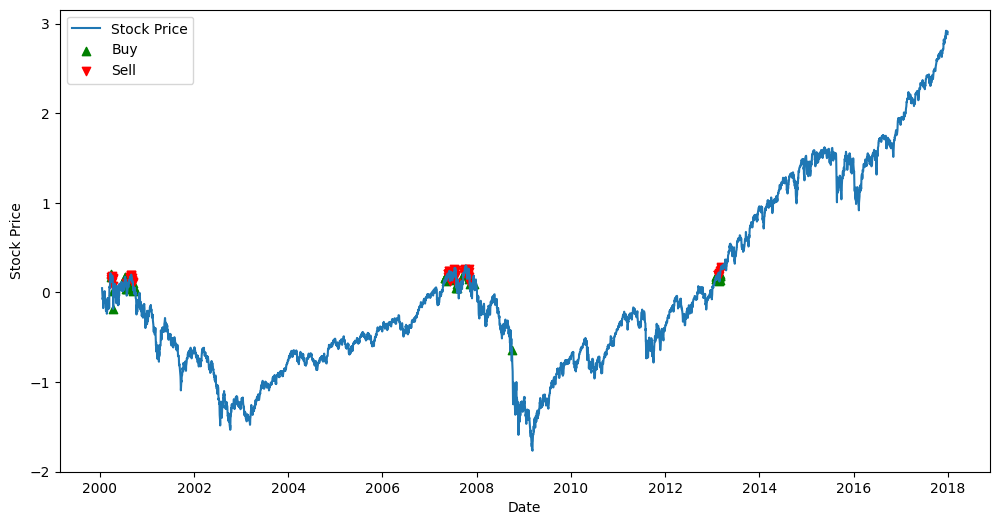

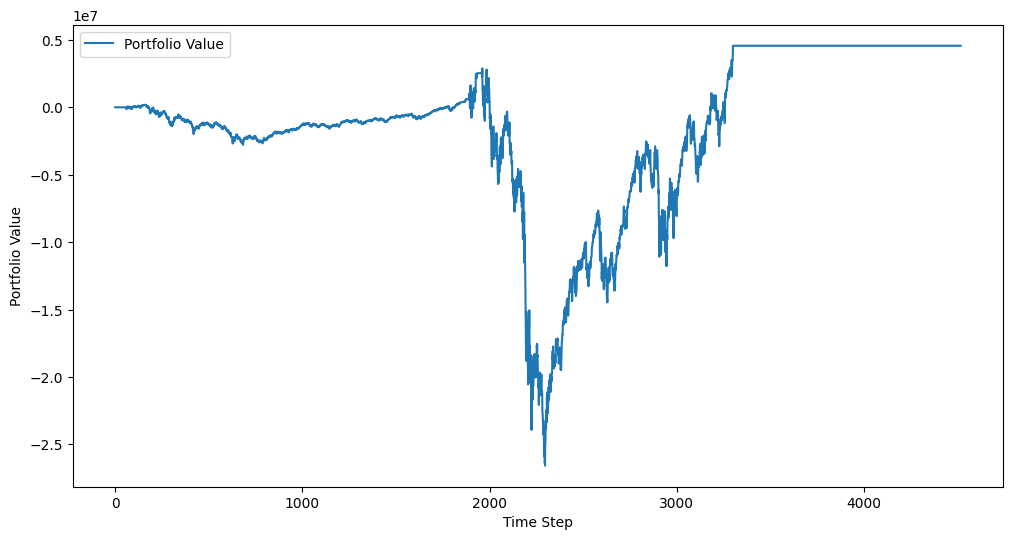

In [78]:
# Get the dates and prices from the new dataset
dates = new_data['Date'].iloc[window_size:]
prices = new_data['Adj Close'].iloc[window_size:]

# Identify buy and sell points
buy_points = []
sell_points = []
for i, action in enumerate(actions):
    if action == 1:  # Buy
        buy_points.append((dates.iloc[i], prices.iloc[i]))
    elif action == 2:  # Sell
        sell_points.append((dates.iloc[i], prices.iloc[i]))

# Plot the stock price with buy/sell indicators
plt.figure(figsize=(12, 6))
plt.plot(dates, prices, label='Stock Price')
if buy_points:
    plt.scatter(*zip(*buy_points), marker='^', color='g', label='Buy')
if sell_points:
    plt.scatter(*zip(*sell_points), marker='v', color='r', label='Sell')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Plot the portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label='Portfolio Value')
plt.xlabel('Time Step')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()


Let's test on one more dataset

In [79]:
# Function to load the model
def load_model(model_path, state_size, action_size):
    model = QNetwork(state_size, action_size)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Load and preprocess the data
data = pd.read_csv('FB_2018.csv')  # Replace with your actual data file
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
data['Return'] = data['Adj Close'].pct_change()
data = data.dropna()

# Keep original prices for plotting
original_prices = data['Adj Close'].values

# Normalizing the data
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
data[features] = data[features].apply(lambda x: (x - x.mean()) / x.std())

# Prepare state representation
window_size = 10
states = []
for i in range(window_size, len(data)):
    state = data[features].iloc[i-window_size:i].values
    states.append(state)
states = np.array(states)
actions = data['Adj Close'].iloc[window_size:].values
original_prices = original_prices[window_size:]



In [80]:
# Function to evaluate the model on a new dataset
def evaluate_model(model, env):
    state = env.reset()
    initial_portfolio_value = env.initial_balance  # Initial portfolio value
    done = False
    portfolio_values = [env.portfolio_value]
    actions = []
    buy_points = []
    sell_points = []

    while not done:
        state = state.flatten()
        state_tensor = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            action_values = model(state_tensor)
        action = np.argmax(action_values.cpu().data.numpy())
        next_state, _, done, _ = env.step(action)  # We don't need the reward here
        state = next_state
        portfolio_values.append(env.portfolio_value)
        actions.append(action)
        
        # Track buy/sell actions with original prices
        if action == 1:  # Buy
            buy_points.append((env.current_step, env.original_prices[env.current_step]))
        elif action == 2:  # Sell
            sell_points.append((env.current_step, env.original_prices[env.current_step]))
    
    final_portfolio_value = portfolio_values[-1]
    roi = (final_portfolio_value - initial_portfolio_value) / initial_portfolio_value  # Calculate ROI
    return initial_portfolio_value, final_portfolio_value, roi, portfolio_values, actions, buy_points, sell_points

# Load the new dataset
new_data = pd.read_csv('FB_2018.csv')  # Replace with your new data file
new_data['Date'] = pd.to_datetime(new_data['Date'])
new_data = new_data.sort_values('Date')
new_data['Return'] = new_data['Adj Close'].pct_change()
new_data = new_data.dropna()

# Keep original prices for plotting
new_original_prices = new_data['Adj Close'].values

# Normalizing the new data
new_data[features] = new_data[features].apply(lambda x: (x - x.mean()) / x.std())

# Prepare new state representation
new_states = []
for i in range(window_size, len(new_data)):
    state = new_data[features].iloc[i-window_size:i].values
    new_states.append(state)
new_states = np.array(new_states)
new_actions = new_data['Adj Close'].iloc[window_size:].values
new_original_prices = new_original_prices[window_size:]

# Instantiate the new environment
new_env = TradingEnv(new_states, new_actions, new_original_prices)

# Load the trained model
trained_model = load_model('ddqn_trading_model.pth', state_size, action_size)

# Evaluate the model on the new dataset
initial_portfolio_value, final_portfolio_value, roi, portfolio_values, actions, buy_points, sell_points = evaluate_model(trained_model, new_env)

# Print the initial and final portfolio values, ROI, and buy/sell points
print(f'Initial Portfolio Value: {initial_portfolio_value}')
print(f'Final Portfolio Value: {final_portfolio_value}')
print(f'Return on Investment (ROI): {roi * 100:.2f}%')

print("\nBuy Points:")
for step, price in buy_points:
    print(f"Step: {step}, Price: {price}")

print("\nSell Points:")
for step, price in sell_points:
    print(f"Step: {step}, Price: {price}")


Initial Portfolio Value: 10000
Final Portfolio Value: -634475.4824354034
Return on Investment (ROI): -6444.75%

Buy Points:
Step: 44, Price: 164.889999
Step: 45, Price: 159.389999
Step: 51, Price: 156.110001
Step: 153, Price: 177.460007
Step: 160, Price: 162.529999

Sell Points:
Step: 77, Price: 182.660004
Step: 151, Price: 172.899994
Step: 152, Price: 174.649994
Step: 154, Price: 176.259995
Step: 156, Price: 177.639999
Step: 157, Price: 175.729996
Step: 159, Price: 167.179993


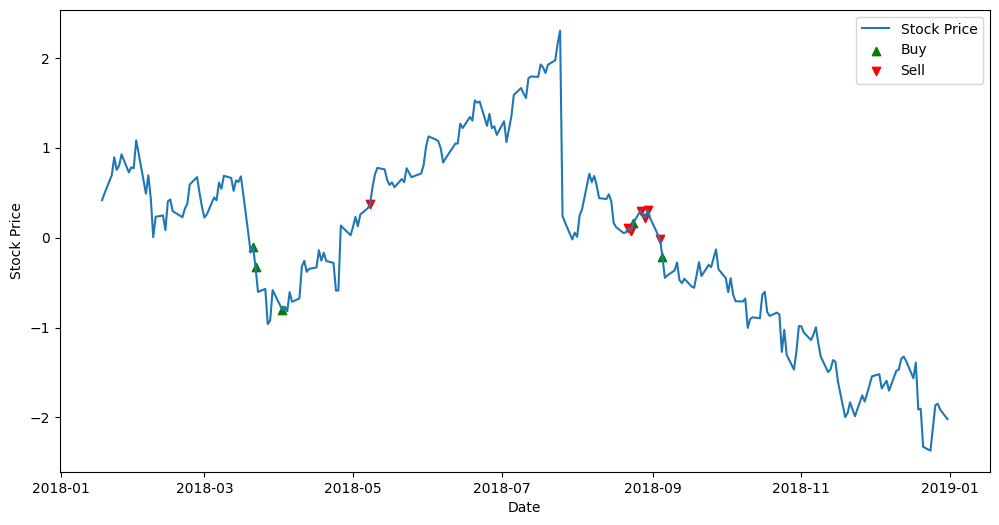

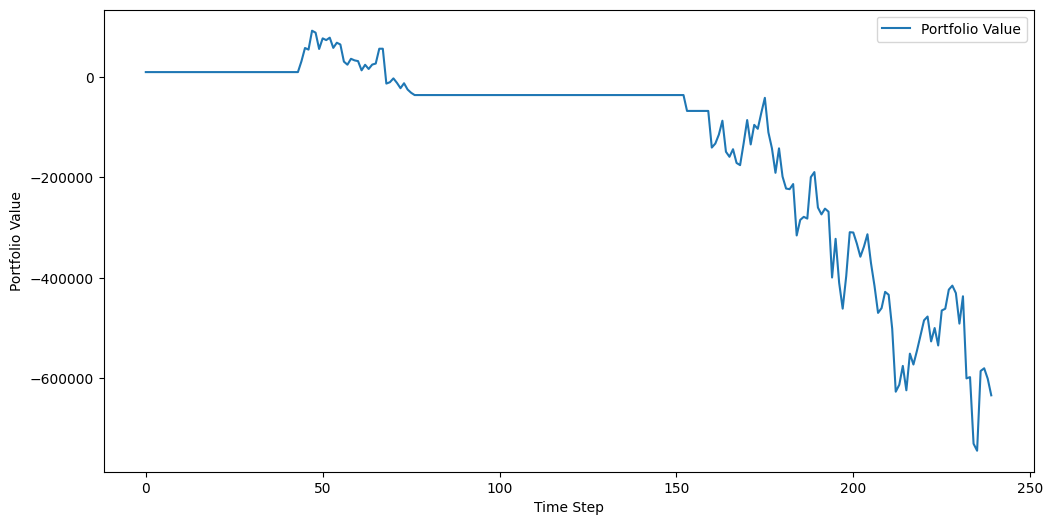

In [81]:
# Get the dates and prices from the new dataset
dates = new_data['Date'].iloc[window_size:]
prices = new_data['Adj Close'].iloc[window_size:]

# Identify buy and sell points
buy_points = []
sell_points = []
for i, action in enumerate(actions):
    if action == 1:  # Buy
        buy_points.append((dates.iloc[i], prices.iloc[i]))
    elif action == 2:  # Sell
        sell_points.append((dates.iloc[i], prices.iloc[i]))

# Plot the stock price with buy/sell indicators
plt.figure(figsize=(12, 6))
plt.plot(dates, prices, label='Stock Price')
if buy_points:
    plt.scatter(*zip(*buy_points), marker='^', color='g', label='Buy')
if sell_points:
    plt.scatter(*zip(*sell_points), marker='v', color='r', label='Sell')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Plot the portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label='Portfolio Value')
plt.xlabel('Time Step')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()


Let's test on BABA datset


In [86]:
# Function to load the model
def load_model(model_path, state_size, action_size):
    model = QNetwork(state_size, action_size)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Load and preprocess the data
data = pd.read_csv('BABA_2018.csv')  # Replace with your actual data file
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
data['Return'] = data['Adj Close'].pct_change()
data = data.dropna()

# Keep original prices for plotting
original_prices = data['Adj Close'].values

# Normalizing the data
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
data[features] = data[features].apply(lambda x: (x - x.mean()) / x.std())

# Prepare state representation
window_size = 10
states = []
for i in range(window_size, len(data)):
    state = data[features].iloc[i-window_size:i].values
    states.append(state)
states = np.array(states)
actions = data['Adj Close'].iloc[window_size:].values
original_prices = original_prices[window_size:]



In [87]:
# Function to evaluate the model on a new dataset
def evaluate_model(model, env):
    state = env.reset()
    initial_portfolio_value = env.initial_balance  # Initial portfolio value
    done = False
    portfolio_values = [env.portfolio_value]
    actions = []
    buy_points = []
    sell_points = []

    while not done:
        state = state.flatten()
        state_tensor = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            action_values = model(state_tensor)
        action = np.argmax(action_values.cpu().data.numpy())
        next_state, _, done, _ = env.step(action)  # We don't need the reward here
        state = next_state
        portfolio_values.append(env.portfolio_value)
        actions.append(action)
        
        # Track buy/sell actions with original prices
        if action == 1:  # Buy
            buy_points.append((env.current_step, env.original_prices[env.current_step]))
        elif action == 2:  # Sell
            sell_points.append((env.current_step, env.original_prices[env.current_step]))
    
    final_portfolio_value = portfolio_values[-1]
    roi = (final_portfolio_value - initial_portfolio_value) / initial_portfolio_value  # Calculate ROI
    return initial_portfolio_value, final_portfolio_value, roi, portfolio_values, actions, buy_points, sell_points

# Load the new dataset
new_data = pd.read_csv('BABA_2018.csv')  # Replace with your new data file
new_data['Date'] = pd.to_datetime(new_data['Date'])
new_data = new_data.sort_values('Date')
new_data['Return'] = new_data['Adj Close'].pct_change()
new_data = new_data.dropna()

# Keep original prices for plotting
new_original_prices = new_data['Adj Close'].values

# Normalizing the new data
new_data[features] = new_data[features].apply(lambda x: (x - x.mean()) / x.std())

# Prepare new state representation
new_states = []
for i in range(window_size, len(new_data)):
    state = new_data[features].iloc[i-window_size:i].values
    new_states.append(state)
new_states = np.array(new_states)
new_actions = new_data['Adj Close'].iloc[window_size:].values
new_original_prices = new_original_prices[window_size:]

# Instantiate the new environment
new_env = TradingEnv(new_states, new_actions, new_original_prices)

# Load the trained model
trained_model = load_model('ddqn_trading_model.pth', state_size, action_size)

# Evaluate the model on the new dataset
initial_portfolio_value, final_portfolio_value, roi, portfolio_values, actions, buy_points, sell_points = evaluate_model(trained_model, new_env)

# Print the initial and final portfolio values, ROI, and buy/sell points
print(f'Initial Portfolio Value: {initial_portfolio_value}')
print(f'Final Portfolio Value: {final_portfolio_value}')
print(f'Return on Investment (ROI): {roi * 100:.2f}%')

print("\nBuy Points:")
for step, price in buy_points:
    print(f"Step: {step}, Price: {price}")

print("\nSell Points:")
for step, price in sell_points:
    print(f"Step: {step}, Price: {price}")


Initial Portfolio Value: 10000
Final Portfolio Value: -47510.394274993996
Return on Investment (ROI): -575.10%

Buy Points:
Step: 54, Price: 167.520004
Step: 74, Price: 188.889999
Step: 145, Price: 169.830002

Sell Points:
Step: 53, Price: 172.570007
Step: 142, Price: 180.009995
Step: 143, Price: 177.679993
Step: 144, Price: 172.529999


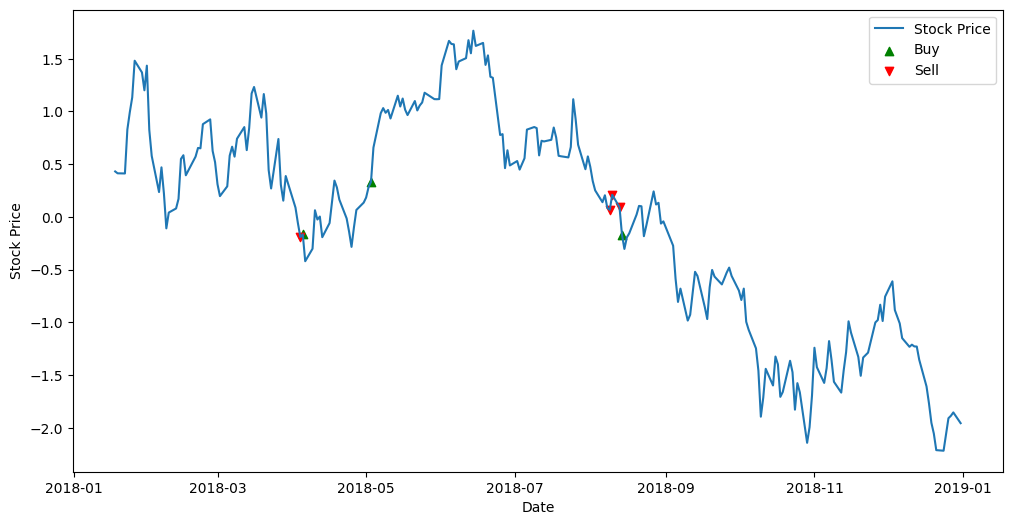

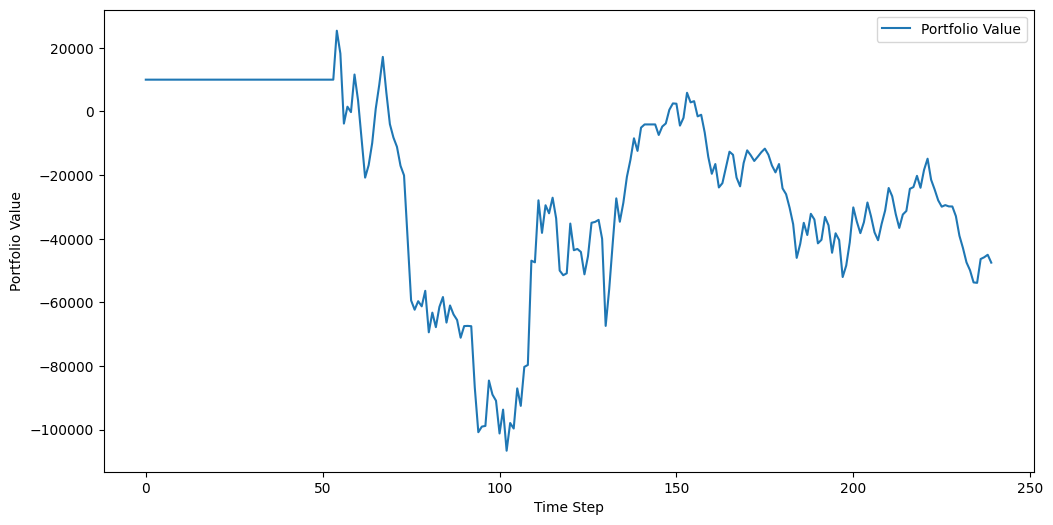

In [88]:
# Get the dates and prices from the new dataset
dates = new_data['Date'].iloc[window_size:]
prices = new_data['Adj Close'].iloc[window_size:]

# Identify buy and sell points
buy_points = []
sell_points = []
for i, action in enumerate(actions):
    if action == 1:  # Buy
        buy_points.append((dates.iloc[i], prices.iloc[i]))
    elif action == 2:  # Sell
        sell_points.append((dates.iloc[i], prices.iloc[i]))

# Plot the stock price with buy/sell indicators
plt.figure(figsize=(12, 6))
plt.plot(dates, prices, label='Stock Price')
if buy_points:
    plt.scatter(*zip(*buy_points), marker='^', color='g', label='Buy')
if sell_points:
    plt.scatter(*zip(*sell_points), marker='v', color='r', label='Sell')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Plot the portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label='Portfolio Value')
plt.xlabel('Time Step')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()


Testing on GSPC 2018 dataset


In [89]:
# Function to load the model
def load_model(model_path, state_size, action_size):
    model = QNetwork(state_size, action_size)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Load and preprocess the data
data = pd.read_csv('^GSPC_2018.csv')  # Replace with your actual data file
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
data['Return'] = data['Adj Close'].pct_change()
data = data.dropna()

# Keep original prices for plotting
original_prices = data['Adj Close'].values

# Normalizing the data
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
data[features] = data[features].apply(lambda x: (x - x.mean()) / x.std())

# Prepare state representation
window_size = 10
states = []
for i in range(window_size, len(data)):
    state = data[features].iloc[i-window_size:i].values
    states.append(state)
states = np.array(states)
actions = data['Adj Close'].iloc[window_size:].values
original_prices = original_prices[window_size:]



In [90]:
# Function to evaluate the model on a new dataset
def evaluate_model(model, env):
    state = env.reset()
    initial_portfolio_value = env.initial_balance  # Initial portfolio value
    done = False
    portfolio_values = [env.portfolio_value]
    actions = []
    buy_points = []
    sell_points = []

    while not done:
        state = state.flatten()
        state_tensor = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            action_values = model(state_tensor)
        action = np.argmax(action_values.cpu().data.numpy())
        next_state, _, done, _ = env.step(action)  # We don't need the reward here
        state = next_state
        portfolio_values.append(env.portfolio_value)
        actions.append(action)
        
        # Track buy/sell actions with original prices
        if action == 1:  # Buy
            buy_points.append((env.current_step, env.original_prices[env.current_step]))
        elif action == 2:  # Sell
            sell_points.append((env.current_step, env.original_prices[env.current_step]))
    
    final_portfolio_value = portfolio_values[-1]
    roi = (final_portfolio_value - initial_portfolio_value) / initial_portfolio_value  # Calculate ROI
    return initial_portfolio_value, final_portfolio_value, roi, portfolio_values, actions, buy_points, sell_points

# Load the new dataset
new_data = pd.read_csv('^GSPC_2018.csv')  # Replace with your new data file
new_data['Date'] = pd.to_datetime(new_data['Date'])
new_data = new_data.sort_values('Date')
new_data['Return'] = new_data['Adj Close'].pct_change()
new_data = new_data.dropna()

# Keep original prices for plotting
new_original_prices = new_data['Adj Close'].values

# Normalizing the new data
new_data[features] = new_data[features].apply(lambda x: (x - x.mean()) / x.std())

# Prepare new state representation
new_states = []
for i in range(window_size, len(new_data)):
    state = new_data[features].iloc[i-window_size:i].values
    new_states.append(state)
new_states = np.array(new_states)
new_actions = new_data['Adj Close'].iloc[window_size:].values
new_original_prices = new_original_prices[window_size:]

# Instantiate the new environment
new_env = TradingEnv(new_states, new_actions, new_original_prices)

# Load the trained model
trained_model = load_model('ddqn_trading_model.pth', state_size, action_size)

# Evaluate the model on the new dataset
initial_portfolio_value, final_portfolio_value, roi, portfolio_values, actions, buy_points, sell_points = evaluate_model(trained_model, new_env)

# Print the initial and final portfolio values, ROI, and buy/sell points
print(f'Initial Portfolio Value: {initial_portfolio_value}')
print(f'Final Portfolio Value: {final_portfolio_value}')
print(f'Return on Investment (ROI): {roi * 100:.2f}%')

print("\nBuy Points:")
for step, price in buy_points:
    print(f"Step: {step}, Price: {price}")

print("\nSell Points:")
for step, price in sell_points:
    print(f"Step: {step}, Price: {price}")


Initial Portfolio Value: 10000
Final Portfolio Value: 14150.072096589842
Return on Investment (ROI): 41.50%

Buy Points:
Step: 14, Price: 2681.659912
Step: 109, Price: 2717.070068
Step: 110, Price: 2723.060059
Step: 117, Price: 2759.820068
Step: 119, Price: 2793.840088
Step: 121, Price: 2798.290039
Step: 195, Price: 2705.570068
Step: 205, Price: 2806.830078
Step: 206, Price: 2781.01001

Sell Points:
Step: 101, Price: 2775.629883
Step: 107, Price: 2749.76001
Step: 194, Price: 2656.100098


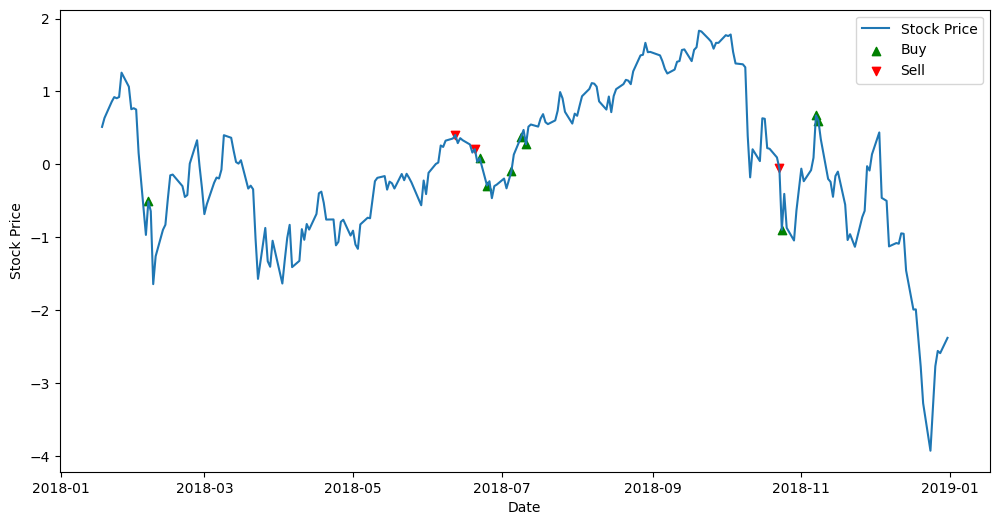

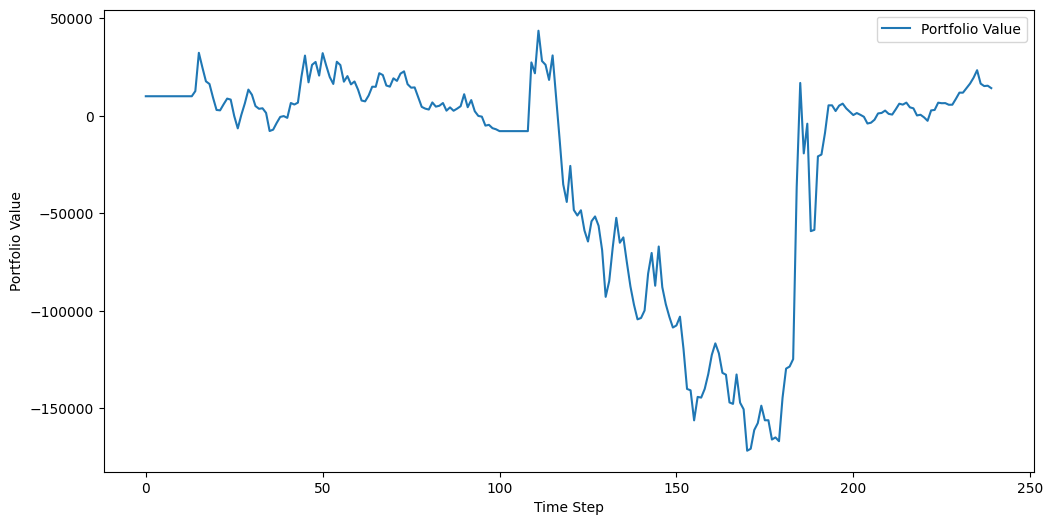

In [91]:
# Get the dates and prices from the new dataset
dates = new_data['Date'].iloc[window_size:]
prices = new_data['Adj Close'].iloc[window_size:]

# Identify buy and sell points
buy_points = []
sell_points = []
for i, action in enumerate(actions):
    if action == 1:  # Buy
        buy_points.append((dates.iloc[i], prices.iloc[i]))
    elif action == 2:  # Sell
        sell_points.append((dates.iloc[i], prices.iloc[i]))

# Plot the stock price with buy/sell indicators
plt.figure(figsize=(12, 6))
plt.plot(dates, prices, label='Stock Price')
if buy_points:
    plt.scatter(*zip(*buy_points), marker='^', color='g', label='Buy')
if sell_points:
    plt.scatter(*zip(*sell_points), marker='v', color='r', label='Sell')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Plot the portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label='Portfolio Value')
plt.xlabel('Time Step')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()


# Conclusion
From all the above resuls we can draw following conclusions:
1) As model is trained on GSPC data it is giving good results for GSPC data of different years. So to apply this trader let's say for NVDA dataset, we should first train it on NVDA past data of about 10 years.
2) It is giving good results when stocks' trend is good. If stock is decreasing for a long time then our portfolio is also going lower and lower (portfolio which is handled by the model.)